In [1]:
%load_ext autoreload
%autoreload 2

## Logistic Regression
<center><img src="../../img/regression_logistic.png" width="700"></center>

In [2]:
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

sys.path.append('..')
from utils.preprocessing import load_dataframes

from constants import CATEGORIES

## Preprocessing

In [137]:
from utils.tokenize_api import preprocess_text

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/camilziane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camilziane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/camilziane/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/camilziane/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [139]:
preprocess_text("Hello, this is a test !")

'hello , test !'

In [3]:
# from utils.tokenize_api import preprocess_text, gpt_tokenize
# from nltk.tokenize import word_tokenize
# params ={ 
#     "word_tokenize_no_normalization":
#     {
#         "tokenize": word_tokenize,
#         "is_remove_special_characters": False,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": False,
#         "is_lemmatization": False,
#     },
#     "gpt_tokenize_no_normalization":
#     {
#         "tokenize": gpt_tokenize,
#         "is_remove_special_characters": False,
#         "remove_stopwords": False,
#         "is_replace_emojis": False,
#         "is_lowercase": False,
#         "is_lemmatization": False,
#     },
#     "word_tokenize_normalization":
#     {
#         "tokenize": word_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": True,
#         "is_replace_emojis": True,
#         "is_lowercase": True,
#         "is_lemmatization": True,
#     },
#     "gpt_tokenize_normalization":
#     {
#         "tokenize": gpt_tokenize,
#         "is_remove_special_characters": True,
#         "remove_stopwords": True,
#         "is_replace_emojis": True,
#         "is_lowercase": True,
#         "is_lemmatization": True,
#     },
#     "word_tokenize_simple_normalization":
#     {
#         "tokenize": word_tokenize,
#         "is_remove_special_characters": False,
#         "remove_stopwords": True,
#         "is_replace_emojis": False,
#         "is_lowercase": True,
#         "is_lemmatization": False,
#     },
#     "gpt_tokenize_simple_normalization":
#     {
#         "tokenize": gpt_tokenize,
#         "is_remove_special_characters": False,
#         "remove_stopwords": True,
#         "is_replace_emojis": False,
#         "is_lowercase": True,
#         "is_lemmatization": False,
#     },
# }

# (df_train, df_val, df_test) = load_dataframes()
# for tn, p in params.items():
#     print(f"Processing {tn}")
#     df_train[f'comment_text_{tn}'] = df_train['comment_text'].apply(lambda x: preprocess_text(x, **p))
#     df_val[f'comment_text_{tn}'] = df_val['comment_text'].apply(lambda x: preprocess_text(x, **p))
#     df_test[f'comment_text_{tn}'] = df_test['comment_text'].apply(lambda x: preprocess_text(x, **p))

# df_train.rename(columns={'comment_text': 'comment_text_baseline'}, inplace=True)
# df_val.rename(columns={'comment_text': 'comment_text_baseline'}, inplace=True)
# df_test.rename(columns={'comment_text': 'comment_text_baseline'}, inplace=True)

# df_train.to_parquet('data/df_train_preprocessed.parquet')
# df_val.to_parquet('data/df_val_preprocessed.parquet')
# df_test.to_parquet('data/df_test_preprocessed.parquet')

### Load parquet

In [4]:
df_train = pd.read_parquet('data/df_train_preprocessed.parquet')
df_val = pd.read_parquet('data/df_val_preprocessed.parquet')
df_test = pd.read_parquet('data/df_test_preprocessed.parquet')

# Binary Classification

In [28]:
y_train = df_train['overall_toxic']
y_valid = df_val['overall_toxic']
y_test = df_test['overall_toxic']

## TF-IDF

In [9]:
import pickle

### Vectorize

In [40]:
preprocess_types = [
    "baseline",
    "word_tokenize_no_normalization",
    "gpt_tokenize_no_normalization",
    "word_tokenize_normalization",
    "gpt_tokenize_normalization",
    "word_tokenize_simple_normalization",
    "gpt_tokenize_simple_normalization",
]

In [116]:
def tfidf_vectorize_and_split(preprocess_type: str) -> tuple:
    vectorizer = TfidfVectorizer(tokenizer=str.split)
    X_train = vectorizer.fit_transform(df_train[f"comment_text_{preprocess_type}"])
    X_valid = vectorizer.transform(df_val[f"comment_text_{preprocess_type}"])
    X_test = vectorizer.transform(df_test[f"comment_text_{preprocess_type}"])
    return (X_train, X_valid, X_test, vectorizer)

In [117]:
# Xs = {preprocess_type: tfidf_vectorize_and_split(preprocess_type) for preprocess_type in preprocess_types}
# with open('data/Xs_tf_idf.pickle', 'wb') as file:
#     pickle.dump(Xs, file, protocol=pickle.HIGHEST_PROTOCOL)

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [118]:
with open('data/Xs_tf_idf.pickle', 'rb') as file:
    Xs = pickle.load(file)

### Train 

In [44]:
def logistic_regression_from_preprocess(preprocess_type:str  ,is_val = True , model=None, logistic_regression_args={}):
    X_train, X_val, X_test, _ = Xs[preprocess_type] 
    if model is None:
        model = LogisticRegression(max_iter=1000, class_weight="balanced", **logistic_regression_args)
        model.fit(X_train, y_train)
    if is_val:
        y_pred = model.predict(X_val)
        return model, y_valid, y_pred
    if not is_val:
        y_pred = model.predict(X_test)
        return model, y_test, y_pred

In [ ]:
def get_macro_results(results):
    macro_results = {}
    for preprocess_type, (_, y_true, y_pred) in results.items():
        report = classification_report(y_true, y_pred, target_names=['non-toxic', 'toxic'], output_dict=True)
        macro_results[preprocess_type] = report['macro avg']
    return macro_results


In [ ]:
def print_results(results):
    for preprocess_type, (_, y_true, y_pred) in results.items():
        print(preprocess_type)
        print(classification_report(y_true, y_pred, target_names=['non-toxic', 'toxic']))

In [45]:
logistic_regression_val_results = {preprocess_type: logistic_regression_from_preprocess(preprocess_type, is_val=True) for preprocess_type in preprocess_types}

### Macro Val Results

In [62]:
macro_val_results = get_macro_results(logistic_regression_val_results)

#### F1 Sorted

In [77]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
macro_result_sorted

{'word_tokenize_simple_normalization': {'precision': 0.8204311753317303,
  'recall': 0.900136948443675,
  'f1-score': 0.8540524441880634,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.8115416744475568,
  'recall': 0.9035844798816937,
  'f1-score': 0.8490960557695992,
  'support': 31915.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.8052988022143235,
  'recall': 0.8770588767565504,
  'f1-score': 0.835809558812534,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision': 0.8032786675938985,
  'recall': 0.8792549126896956,
  'f1-score': 0.8352299509750643,
  'support': 31915.0},
 'baseline': {'precision': 0.7945667175349894,
  'recall': 0.8872976367249163,
  'f1-score': 0.8318030410620597,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.7945667175349894,
  'recal

Best is word_tokenize_simple_normalization with a f1 score of 0.854, baseline is 0.8318

#### Recall Sorted

In [76]:
macro_result_sorted = {k: v for k, v in sorted(macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
macro_result_sorted

{'word_tokenize_no_normalization': {'precision': 0.8156686985399396,
  'recall': 0.9080655595275127,
  'f1-score': 0.8534588695460361,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.8115416744475568,
  'recall': 0.9035844798816937,
  'f1-score': 0.8490960557695992,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.8204311753317303,
  'recall': 0.900136948443675,
  'f1-score': 0.8540524441880634,
  'support': 31915.0},
 'baseline': {'precision': 0.7945667175349894,
  'recall': 0.8872976367249163,
  'f1-score': 0.8318030410620597,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.7945667175349894,
  'recall': 0.8872976367249163,
  'f1-score': 0.8318030410620597,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision': 0.8032786675938985,
  'recall': 0.8792549126896956,
  'f1-score': 0.8352299509750643,
  'support': 31915.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.8052988022143235,
  'reca

Best is word_tokenize_no_normalization with a recall score of 0.91 , baseline is 0.89

### Optuna – Search Best Hyperparameters

In [83]:
import optuna
import numpy as np
from sklearn.metrics import recall_score, f1_score
from typing import Literal
from functools import partial

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [84]:
X_train, X_val, X_test, _ = Xs["word_tokenize_simple_normalization"]

In [85]:
def objective(metric: Literal["recall_score", "f1_score"], trial):
    # Load data
    # Suggest values for the hyperparameters

    penalty = trial.suggest_categorical("penalty", ["l1", "l2", None])
    C = trial.suggest_float("C", 0.1, 10, log=True)

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        solver="liblinear" if penalty == "l1" else "lbfgs",
        max_iter=1000,
        class_weight="balanced",
    )

    # Train and evaluate the model
    model.fit(X_train, y_train)
    pred_y = model.predict(X_val)
    score = 0
    if metric == "recall_score":
        score = recall_score(y_valid, pred_y, average="macro")
    if metric == "f1_score":
        score = f1_score(y_valid, pred_y, average="macro")
    return score

In [86]:
objective_recall = partial(objective, "recall_score")
objective_f1_score = partial(objective, "f1_score")

In [87]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_recall, n_trials=25)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-05-11 14:59:09,833] A new study created in memory with name: no-name-0e59e6e6-886b-40bb-a9bc-e08690cf27d4
[I 2024-05-11 14:59:11,772] Trial 0 finished with value: 0.8893202910729106 and parameters: {'penalty': 'l2', 'C': 0.17637376601041613}. Best is trial 0 with value: 0.8893202910729106.
[I 2024-05-11 14:59:15,421] Trial 1 finished with value: 0.9029710750574322 and parameters: {'penalty': 'l2', 'C': 2.144974799222896}. Best is trial 1 with value: 0.9029710750574322.
[I 2024-05-11 14:59:17,825] Trial 2 finished with value: 0.9029569634779637 and parameters: {'penalty': 'l2', 'C': 1.7319620263809183}. Best is trial 1 with value: 0.9029710750574322.
[I 2024-05-11 14:59:20,366] Trial 3 finished with value: 0.9073315961199511 and parameters: {'penalty': 'l1', 'C': 0.9834294367477637}. Best is trial 3 with value: 0.9073315961199511.
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting pe

Best trial:
  Value: 0.9079868303536773
  Params: 
    penalty: l1
    C: 0.6981375596642669


In [88]:
study = optuna.create_study(direction='maximize')
study.optimize(objective_f1_score, n_trials=25)  # Adjust the number of trials

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-05-11 15:01:22,662] A new study created in memory with name: no-name-a07e8eda-ad09-434c-aefd-138187fefddf
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2024-05-11 15:01:27,337] Trial 0 finished with value: 0.8745686978513579 and parameters: {'penalty': None, 'C': 0.4140225401145443}. Best is trial 0 with value: 0.8745686978513579.
[I 2024-05-11 15:01:31,657] Trial 1 finished with value: 0.8710993231709663 and parameters: {'penalty': 'l1', 'C': 2.3814635009619614}. Best is trial 0 with value: 0.8745686978513579.
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
[I 2024-05-11 15:01:37,234] Trial 2 finished with value: 0.8745686978513579 an

Best trial:
  Value: 0.8745686978513579
  Params: 
    penalty: None
    C: 0.4140225401145443


#### Best Model on Macro Recall
    penalty: l1
    C: 0.6981375596642669

In [91]:
best_recall_logistic_regression_val_results = {preprocess_type: logistic_regression_from_preprocess(preprocess_type, is_val=True, logistic_regression_args={"penalty": "l1", "C": 0.6981375596642669, "solver": "liblinear" }) for preprocess_type in preprocess_types}

In [93]:
best_recall_macro_val_results = get_macro_results(best_recall_logistic_regression_val_results)
best_recall_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_recall_macro_val_result_sorted


{'word_tokenize_no_normalization': {'precision': 0.8149257936753143,
  'recall': 0.9119598555077478,
  'f1-score': 0.8541865855425177,
  'support': 31915.0},
 'word_tokenize_simple_normalization': {'precision': 0.8171384579902308,
  'recall': 0.9079868303536773,
  'f1-score': 0.8544627934979454,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.8081738689964935,
  'recall': 0.9047308347118062,
  'f1-score': 0.8470646590016135,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.7879674727429686,
  'recall': 0.8921846621613689,
  'f1-score': 0.8283908637613144,
  'support': 31915.0},
 'baseline': {'precision': 0.7879032461886595,
  'recall': 0.8921672229370656,
  'f1-score': 0.8283372371176252,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision': 0.7918770347591755,
  'recall': 0.8841221819148922,
  'f1-score': 0.8288703749666526,
  'support': 31915.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.7949944581240603,
  'rec

#### Best Model on Macro F1
    penalty: None

In [94]:
best_f1_logistic_regression_val_results = {preprocess_type: logistic_regression_from_preprocess(preprocess_type, is_val=True, logistic_regression_args={"penalty": None }) for preprocess_type in preprocess_types}

In [97]:
best_f1_macro_val_results = get_macro_results(best_f1_logistic_regression_val_results)
best_f1_macro_val_result_sorted = {k: v for k, v in sorted(best_recall_macro_val_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
best_f1_macro_val_result_sorted

{'word_tokenize_simple_normalization': {'precision': 0.8171384579902308,
  'recall': 0.9079868303536773,
  'f1-score': 0.8544627934979454,
  'support': 31915.0},
 'word_tokenize_no_normalization': {'precision': 0.8149257936753143,
  'recall': 0.9119598555077478,
  'f1-score': 0.8541865855425177,
  'support': 31915.0},
 'word_tokenize_normalization': {'precision': 0.8081738689964935,
  'recall': 0.9047308347118062,
  'f1-score': 0.8470646590016135,
  'support': 31915.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.7949944581240603,
  'recall': 0.8820015475107474,
  'f1-score': 0.8304274579727873,
  'support': 31915.0},
 'gpt_tokenize_normalization': {'precision': 0.7918770347591755,
  'recall': 0.8841221819148922,
  'f1-score': 0.8288703749666526,
  'support': 31915.0},
 'gpt_tokenize_no_normalization': {'precision': 0.7879674727429686,
  'recall': 0.8921846621613689,
  'f1-score': 0.8283908637613144,
  'support': 31915.0},
 'baseline': {'precision': 0.7879032461886595,
  'rec

### Final Test set

In [98]:
best_f1_logistic_regression_test_results = {preprocess_type: logistic_regression_from_preprocess(preprocess_type, is_val=False, logistic_regression_args={"penalty": None }) for preprocess_type in preprocess_types}

#### Macro Test Results

In [99]:
best_f1_macro_test_results = get_macro_results(best_f1_logistic_regression_test_results)

##### F1 Sorted

In [100]:
best_f1_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['f1-score'], reverse=True)}
best_f1_macro_test_result_sorted

{'baseline': {'precision': 0.7513827259093724,
  'recall': 0.8543322493653271,
  'f1-score': 0.7898866876191888,
  'support': 63978.0},
 'gpt_tokenize_no_normalization': {'precision': 0.7513827259093724,
  'recall': 0.8543322493653271,
  'f1-score': 0.7898866876191888,
  'support': 63978.0},
 'word_tokenize_no_normalization': {'precision': 0.7397488788055211,
  'recall': 0.8834222268665509,
  'f1-score': 0.7861189243560747,
  'support': 63978.0},
 'gpt_tokenize_normalization': {'precision': 0.747671289329406,
  'recall': 0.8431176146694535,
  'f1-score': 0.7839656944092854,
  'support': 63978.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.7422099160749702,
  'recall': 0.8598510061068345,
  'f1-score': 0.7836785482193258,
  'support': 63978.0},
 'word_tokenize_normalization': {'precision': 0.729096638897065,
  'recall': 0.8647718513064069,
  'f1-score': 0.7728847939032395,
  'support': 63978.0},
 'word_tokenize_simple_normalization': {'precision': 0.7261624740582656,
  'recal

Best is word_tokenize_simple_normalization with a f1 score of 0.854, baseline is 0.8318

##### Recall Sorted

In [103]:
best_f1_macro_test_result_sorted = {k: v for k, v in sorted(best_f1_macro_test_results.items(), key=lambda item: item[1]['recall'], reverse=True)}
best_f1_macro_test_result_sorted

{'word_tokenize_no_normalization': {'precision': 0.7397488788055211,
  'recall': 0.8834222268665509,
  'f1-score': 0.7861189243560747,
  'support': 63978.0},
 'word_tokenize_simple_normalization': {'precision': 0.7261624740582656,
  'recall': 0.8808017559557586,
  'f1-score': 0.7723983800180094,
  'support': 63978.0},
 'word_tokenize_normalization': {'precision': 0.729096638897065,
  'recall': 0.8647718513064069,
  'f1-score': 0.7728847939032395,
  'support': 63978.0},
 'gpt_tokenize_simple_normalization': {'precision': 0.7422099160749702,
  'recall': 0.8598510061068345,
  'f1-score': 0.7836785482193258,
  'support': 63978.0},
 'baseline': {'precision': 0.7513827259093724,
  'recall': 0.8543322493653271,
  'f1-score': 0.7898866876191888,
  'support': 63978.0},
 'gpt_tokenize_no_normalization': {'precision': 0.7513827259093724,
  'recall': 0.8543322493653271,
  'f1-score': 0.7898866876191888,
  'support': 63978.0},
 'gpt_tokenize_normalization': {'precision': 0.747671289329406,
  'recal

In [127]:
X_train, X_val, X_test, vectorizer = Xs["word_tokenize_normalization"]
best_model = best_f1_logistic_regression_test_results["word_tokenize_normalization"][0]

### Shap Value

In [128]:
import pandas as pd

In [129]:
import shap
masker = shap.maskers.Independent(data=X_train)
explainer = shap.LinearExplainer(best_model, masker)

In [130]:
# Convert csr_matrix to pandas DataFrame
X_train_df = pd.DataFrame(X_train.toarray())

# Select a random subset of your data
subset = X_train_df.sample(n=1000, random_state=0)

In [132]:
shap_values = explainer.shap_values(subset)

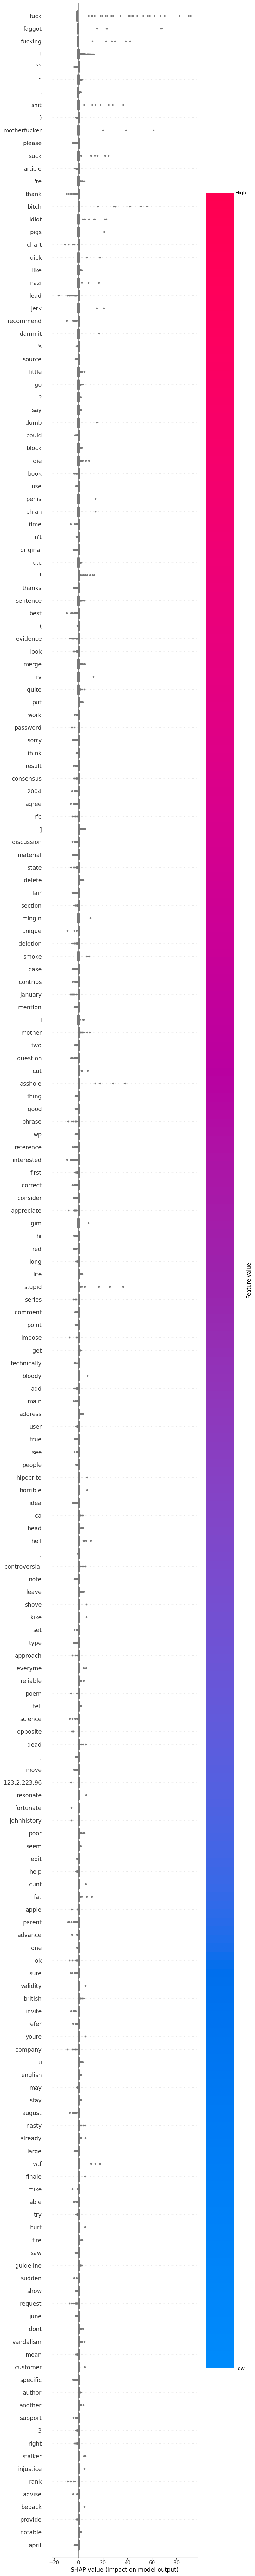

In [136]:
shap.summary_plot(shap_values, X_train, feature_names=vectorizer.get_feature_names_out(), max_display=200)

## Word to Vec

In [ ]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import os
import gensim.downloader

In [41]:
def vectorize_from_pretrained(model_vector: KeyedVectors, x: np.ndarray, y: np.ndarray):
    means = []
    y_range = []
    for i, doc in enumerate(x):
        mean = np.mean([model_vector[word] for word in doc if word in model_vector], axis=0)
        if not(isinstance(mean, np.ndarray) and len(mean) > 0):
            continue
        y_range.append(i)
        means.append(mean)
    return np.vstack(means), y[y_range]

In [42]:
def vectorize_from_scratch(model_vector, x: np.ndarray, y:np.ndarray):
    means = []
    y_range = []
    for i, doc in enumerate(x):
        mean = np.mean([model_vector.wv[word] for word in doc if word in model_vector.wv], axis=0)
        if not(isinstance(mean, np.ndarray) and len(mean) > 0):
            continue
        y_range.append(i)
        means.append(mean)
    return np.vstack(means), y[y_range]

Load word tokenized data

In [49]:
dfs = [df_train, df_val, df_test]
x_token_paths = ["data/x_train_tokens.npy", "data/x_valid_tokens.npy", "data/x_test_tokens.npy"]
x_tokens = []

for df, x_token_path in zip(dfs, x_token_paths):
    if os.path.exists(x_token_path): 
        x_token = np.load(x_token_path, allow_pickle=True)
    else:
        x_token = df.apply(lambda row: word_tokenize(row['comment_text']), axis=1).to_numpy()
        np.save(x_token_path, x_token)
    x_tokens.append(x_token) 

x_train_tokens, x_valid_tokens, x_test_tokens = x_tokens

In [30]:
y_train = df_train['overall_toxic'].to_numpy()
y_valid = df_val['overall_toxic'].to_numpy()
y_test = df_test['overall_toxic'].to_numpy()

### PreTrained

In [58]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [59]:
glove_vectors = gensim.downloader.load('glove-twitter-200')

[==================================================] 100.0% 387.1/387.1MB downloaded


In [60]:
# X_train_w2v,y_train_w2v = vectorize_from_pretrained(glove_vectors, x_train_tokens, y_train) 
# X_valid_w2v ,y_valid_w2v= vectorize_from_pretrained(glove_vectors,x_valid_tokens, y_valid) 
# X_test_w2v, y_test_w2v = vectorize_from_pretrained(glove_vectors,x_test_tokens, y_test)
# np.save("data/X_train_w2v", X_train_w2v)
# np.save("data/y_train_w2v", y_train_w2v)
# np.save("data/X_valid_w2v", X_valid_w2v)
# np.save("data/y_valid_w2v", y_valid_w2v)
# np.save("data/X_test_w2v", X_test_w2v)
# np.save("data/y_test_w2v", y_test_w2v)

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [61]:
X_train_w2v,y_train_w2v = np.load("data/X_train_w2v.npy"), np.load("data/y_train_w2v.npy") 
X_valid_w2v ,y_valid_w2v= np.load("data/X_valid_w2v.npy"), np.load("data/y_valid_w2v.npy")
X_test_w2v, y_test_w2v = np.load("data/X_test_w2v.npy"), np.load("data/y_test_w2v.npy")

In [78]:
model_w2 = LogisticRegression(max_iter=1000, class_weight="balanced")
model_w2.fit(X_train_w2v, y_train_w2v)
print(classification_report(y_valid_w2v, model_w2.predict(X_valid_w2v)))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     28669
           1       0.42      0.83      0.56      3243

    accuracy                           0.86     31912
   macro avg       0.70      0.85      0.74     31912
weighted avg       0.92      0.86      0.88     31912



### Scratch Word2Vec Model

In [67]:
# model_vector = Word2Vec(sentences=x_train_tokens, min_count=1, window=10, workers=8, vector_size=50)
# model_vector.save("data/word2vec_scratch.model")

In [71]:
model_vector = Word2Vec.load("data/word2vec_scratch.model")

In [72]:
X_train_w2v,y_train_w2v = vectorize_from_scratch(model_vector, x_train_tokens, y_train) 
X_valid_w2v ,y_valid_w2v= vectorize_from_scratch(model_vector,x_valid_tokens, y_valid) 
X_test_w2v, y_test_w2v = vectorize_from_scratch(model_vector,x_test_tokens, y_test)
np.save("data/X_train_w2v_scratch", X_train_w2v)
np.save("data/y_train_w2v_scratch", y_train_w2v)
np.save("data/X_valid_w2v_scratch", X_valid_w2v)
np.save("data/y_valid_w2v_scratch", y_valid_w2v)
np.save("data/X_test_w2v_scratch", X_test_w2v)
np.save("data/y_test_w2v_scratch", y_test_w2v)

/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [73]:
X_train_w2v,y_train_w2v = np.load("data/X_train_w2v_scratch.npy"), np.load("data/y_train_w2v_scratch.npy") 
X_valid_w2v ,y_valid_w2v= np.load("data/X_valid_w2v_scratch.npy"), np.load("data/y_valid_w2v_scratch.npy")
X_test_w2v, y_test_w2v = np.load("data/X_test_w2v_scratch.npy"), np.load("data/y_test_w2v_scratch.npy")

In [77]:
model_w2 = LogisticRegression(max_iter=1000,class_weight="balanced")
model_w2.fit(X_train_w2v, y_train_w2v)
print(classification_report(y_valid_w2v, model_w2.predict(X_valid_w2v)))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92     28669
           1       0.42      0.83      0.56      3243

    accuracy                           0.86     31912
   macro avg       0.70      0.85      0.74     31912
weighted avg       0.92      0.86      0.88     31912



# Multilabel Logistic Regression

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
CATEGORIES += ["overall_toxic"]

In [ ]:
y_train = df_train[CATEGORIES]
y_val_cat = df_val[CATEGORIES]

### Best Macro Recall Model 

In [ ]:
classifier = OneVsRestClassifier(LogisticRegression(**best_model.get_params()))
classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=2.233,
                                                 class_weight='balanced',
                                                 max_iter=1000))

In [ ]:
y_pred = classifier.predict(X_valid)
print(classification_report(y_val_cat, y_pred, target_names=CATEGORIES))
accuracy_score(y_val_cat, y_pred)

               precision    recall  f1-score   support

        toxic       0.67      0.84      0.75      3056
 severe_toxic       0.29      0.79      0.43       321
      obscene       0.73      0.88      0.80      1715
       threat       0.22      0.68      0.34        74
       insult       0.59      0.84      0.69      1614
identity_hate       0.30      0.71      0.42       294
overall_toxic       0.69      0.85      0.76      3244

    micro avg       0.62      0.84      0.72     10318
    macro avg       0.50      0.80      0.60     10318
 weighted avg       0.65      0.84      0.73     10318
  samples avg       0.07      0.08      0.07     10318



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to contr

0.8813410621964594

### Best Macro F1 Model 

In [ ]:
f1_classifier = OneVsRestClassifier(LogisticRegression(**best_model_f1.get_params()))
f1_classifier.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000, penalty=None))

In [ ]:
y_pred = f1_classifier.predict(X_valid)
print(classification_report(y_val_cat, y_pred, target_names=CATEGORIES))
accuracy_score(y_val_cat, y_pred)

               precision    recall  f1-score   support

        toxic       0.72      0.76      0.74      3056
 severe_toxic       0.34      0.55      0.42       321
      obscene       0.78      0.76      0.77      1715
       threat       0.24      0.45      0.31        74
       insult       0.63      0.70      0.66      1614
identity_hate       0.37      0.57      0.45       294
overall_toxic       0.76      0.76      0.76      3244

    micro avg       0.69      0.74      0.71     10318
    macro avg       0.55      0.65      0.59     10318
 weighted avg       0.71      0.74      0.72     10318
  samples avg       0.07      0.07      0.07     10318



/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/camilziane/.pyenv/versions/3.11.6/envs/nlp_project/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to contr

0.8867617107942973